## Bases de Datos Sintéticas en Real Estate: Aplicaciones de la IA Generativa

#### Maestría en Inteligencia Artificial Aplicada - MNA
##### Proyecto integrador (Gpo 10)

###### Sarah Mendoza Medina A01215352
###### Pablo Mecate Pantoja A01794765


In [45]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
import gc
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import csv
import datetime
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# Librerías para manejo de geometría
import geopandas as gpd
from shapely.geometry import Point


In [90]:
# Ruta al archivo Excel
file_path = '/Users/sarahmendoza/Documents/Maestria/Proyecto integrador/renta_CDMX_2024.csv'

# Leer el archivo 
df = pd.read_csv(file_path)

# Mostrar las primeras filas
df.head()

/var/folders/ns/82j_1hfj7f188gzxpzd27zfh0000gn/T/ipykernel_81561/2753759782.py:5: DtypeWarning: Columns (0,2,11,13,15,17,21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,direccion,id_tipo_propiedad,tipo_propiedad,area_construida,recamaras,banos,edad,estacionamientos,latitud,longitud,...,id_cve_geo_col,Colonia,precio_oferta,fecha_oferta,precio_m2,cp,superficie_terreno,amenidades,elevador,ubicacion
0,NaN,4.0,Departamento,74.0,3.0,2.0,5.0,1.0,19.464082,-99.120232,...,9005245.0,Guadalupe Tepeyac,16000.0,15/04/2024,216.216216,7840.0,74.0,NaN,NaN,POINT (-99.1202321 19.4640821)
1,NaN,4.0,Departamento,200.0,3.0,3.0,7.0,3.0,19.382607,-99.161064,...,90142394.0,Del Valle Centro,55000.0,21/02/2024,275.000000,3100.0,200.0,NaN,NaN,POINT (-99.1610642 19.3826071)
2,"Miguel Bernard, Col. La Escalera C.P. 07320, G...",4.0,Departamento,74.0,3.0,1.0,0.0,NaN,19.508087,-99.136730,...,9005217.0,Sierravista,11000.0,19/03/2024,148.648649,7320.0,NaN,"""{'amenidades': {'cocina_amueblada': None, 'pi...",0.0,POINT (-99.1367299 19.5080874)
3,"Norte 79 B 224 A - 1, Col. Un Hogar Para Cada ...",4.0,Departamento,45.0,1.0,1.0,0.0,NaN,19.475753,-99.175971,...,900221.0,Un Hogar Para Cada Trabajador,7600.0,21/03/2024,168.888889,2060.0,NaN,"""{'amenidades': {'cocina_amueblada': None, 'pi...",0.0,POINT (-99.1759713 19.4757532)
4,"SN, Col. Romero Rubio C.P. 15400, Venustiano C...",4.0,Departamento,65.0,2.0,1.0,0.0,NaN,19.442391,-99.096380,...,9017280.0,Romero Rubio,11000.0,16/03/2024,169.230769,15400.0,NaN,"""{'amenidades': {'cocina_amueblada': None, 'pi...",0.0,POINT (-99.09638 19.442391)


In [ ]:
print(df.columns)

Index(['direccion', 'id_tipo_propiedad', 'tipo_propiedad', 'area_construida',
       'recamaras', 'banos', 'edad', 'estacionamientos', 'latitud', 'longitud',
       'id_cve_geo_edo', 'Estado', 'id_cve_geo_muni', 'Minicipio',
       'id_cve_geo_col', 'Colonia', 'precio_oferta', 'fecha_oferta',
       'precio_m2', 'cp', 'superficie_terreno', 'amenidades', 'elevador',
       'ubicacion'],
      dtype='object')


In [ ]:
df.columns = df.columns.str.strip() # Eliminar espacios al principio y al final de los nombres de columnas

# Eliminar columnas no deseadas
columnas_eliminar = [
    'direccion', 'id_tipo_propiedad', 'id_cve_geo_muni',
    'id_cve_geo_col', 'superficie_terreno', 'amenidades',
    'elevador', 'ubicacion'
]

df_clean = df.drop(columns=columnas_eliminar)

# Reordenar columnas 
nuevo_orden = [
    'tipo_propiedad', 'area_construida', 'recamaras', 'banos',
    'edad', 'estacionamientos', 'latitud', 'longitud', 'Municipio',
    'Colonia', 'precio_oferta', 'fecha_oferta', 'precio_m2', 'cp'
]

df_clean = df_clean.rename(columns={'Minicipio': 'Municipio'}) 

df_clean = df_clean[nuevo_orden]

In [ ]:
df_clean.head()

,tipo_propiedad,area_construida,recamaras,banos,edad,estacionamientos,latitud,longitud,Municipio,Colonia,precio_oferta,fecha_oferta,precio_m2,cp
0,Departamento,74.0,3.0,2.0,5.0,1.0,19.464082,-99.120232,Gustavo A. Madero,Guadalupe Tepeyac,16000.0,15/04/2024,216.216216,7840.0
1,Departamento,200.0,3.0,3.0,7.0,3.0,19.382607,-99.161064,Benito Juárez,Del Valle Centro,55000.0,21/02/2024,275.000000,3100.0
2,Departamento,74.0,3.0,1.0,0.0,NaN,19.508087,-99.136730,Gustavo A. Madero,Sierravista,11000.0,19/03/2024,148.648649,7320.0
3,Departamento,45.0,1.0,1.0,0.0,NaN,19.475753,-99.175971,Azcapotzalco,Un Hogar Para Cada Trabajador,7600.0,21/03/2024,168.888889,2060.0
4,Departamento,65.0,2.0,1.0,0.0,NaN,19.442391,-99.096380,Venustiano Carranza,Romero Rubio,11000.0,16/03/2024,169.230769,15400.0


Análisis Exploratorio de Datos (EDA):

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753652 entries, 0 to 753651
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   tipo_propiedad    124516 non-null  object 
 1   area_construida   124516 non-null  float64
 2   recamaras         118743 non-null  float64
 3   banos             115639 non-null  float64
 4   edad              109180 non-null  float64
 5   estacionamientos  75941 non-null   float64
 6   latitud           124516 non-null  float64
 7   longitud          124516 non-null  float64
 8   Municipio         124516 non-null  object 
 9   Colonia           123469 non-null  object 
 10  precio_oferta     124516 non-null  float64
 11  fecha_oferta      124516 non-null  object 
 12  precio_m2         124516 non-null  float64
 13  cp                124515 non-null  float64
dtypes: float64(10), object(4)
memory usage: 80.5+ MB


In [ ]:
df_CDMX = df_clean.dropna(subset=['recamaras', 'banos']) #Eliminar filas si un conjunto específico de columnas tiene nulos

In [ ]:
df_CDMX.fillna(0, inplace=True)  # Reemplaza todos los nulos con 0

/var/folders/ns/82j_1hfj7f188gzxpzd27zfh0000gn/T/ipykernel_81561/3148866280.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CDMX.fillna(0, inplace=True)  # Reemplaza todos los nulos con 0


In [ ]:
#Convertir una columna de tipo object a category para ahorrar memoria o mejorar el rendimiento en operaciones analíticas


columnas_a_convertir = ['Municipio', 'Colonia', 'cp','tipo_propiedad']
for col in columnas_a_convertir:
    df_CDMX[col] = df_CDMX[col].astype('category')

/var/folders/ns/82j_1hfj7f188gzxpzd27zfh0000gn/T/ipykernel_81561/2184837273.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CDMX[col] = df_CDMX[col].astype('category')
/var/folders/ns/82j_1hfj7f188gzxpzd27zfh0000gn/T/ipykernel_81561/2184837273.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CDMX[col] = df_CDMX[col].astype('category')
/var/folders/ns/82j_1hfj7f188gzxpzd27zfh0000gn/T/ipykernel_81561/2184837273.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [ ]:
df_CDMX = df_CDMX.copy()
df_CDMX['fecha_oferta'] = pd.to_datetime(df_CDMX['fecha_oferta'], dayfirst=True)

In [ ]:
# Lista de las columnas a convertir
columnas_a_convertir = ['recamaras', 'banos', 'edad','estacionamientos']

# Convertir las columnas especificadas a enteros
df_CDMX[columnas_a_convertir] = df_CDMX[columnas_a_convertir].astype('int64')

In [ ]:
# Convertir una columna de tipo object a float
#df_CDMX['precio_oferta'] = pd.to_numeric(df_CDMX['precio_oferta'], errors='coerce')

In [ ]:
df_CDMX.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113835 entries, 0 to 124515
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   tipo_propiedad    113835 non-null  category      
 1   area_construida   113835 non-null  float64       
 2   recamaras         113835 non-null  int64         
 3   banos             113835 non-null  int64         
 4   edad              113835 non-null  int64         
 5   estacionamientos  113835 non-null  int64         
 6   latitud           113835 non-null  float64       
 7   longitud          113835 non-null  float64       
 8   Municipio         113835 non-null  category      
 9   Colonia           113835 non-null  category      
 10  precio_oferta     113835 non-null  float64       
 11  fecha_oferta      113835 non-null  datetime64[ns]
 12  precio_m2         113835 non-null  float64       
 13  cp                113835 non-null  category      
dtypes: catego

In [ ]:
df_CDMX.head()

,tipo_propiedad,area_construida,recamaras,banos,edad,estacionamientos,latitud,longitud,Municipio,Colonia,precio_oferta,fecha_oferta,precio_m2,cp
0,Departamento,74.0,3,2,5,1,19.464082,-99.120232,Gustavo A. Madero,Guadalupe Tepeyac,16000.0,2024-04-15,216.216216,7840.0
1,Departamento,200.0,3,3,7,3,19.382607,-99.161064,Benito Juárez,Del Valle Centro,55000.0,2024-02-21,275.000000,3100.0
2,Departamento,74.0,3,1,0,0,19.508087,-99.136730,Gustavo A. Madero,Sierravista,11000.0,2024-03-19,148.648649,7320.0
3,Departamento,45.0,1,1,0,0,19.475753,-99.175971,Azcapotzalco,Un Hogar Para Cada Trabajador,7600.0,2024-03-21,168.888889,2060.0
4,Departamento,65.0,2,1,0,0,19.442391,-99.096380,Venustiano Carranza,Romero Rubio,11000.0,2024-03-16,169.230769,15400.0


In [ ]:
print(df_CDMX.describe())

       area_construida      recamaras          banos           edad  \
count    113835.000000  113835.000000  113835.000000  113835.000000   
mean        165.975229       2.366891       2.103167       7.364870   
min          10.000000       0.000000       0.000000       0.000000   
25%          80.000000       2.000000       2.000000       0.000000   
50%         115.000000       2.000000       2.000000       1.000000   
75%         200.000000       3.000000       3.000000      10.000000   
max        4994.000000      10.000000      10.000000     100.000000   
std         153.221633       0.868559       0.900707      11.581167   

       estacionamientos        latitud       longitud  precio_oferta  \
count     113835.000000  113835.000000  113835.000000  113835.000000   
mean           1.176044      19.396067     -99.192459   41606.136024   
min            0.000000      19.179771     -99.346499    2000.000000   
25%            0.000000      19.363910     -99.211934   20000.000000   


Variables Categóricas

In [ ]:
# Frecuencias para todas las columnas categóricas

categorical_columns = ['tipo_propiedad', 'Municipio', 'Colonia', 'cp']
frecuencias = {}
for col in categorical_columns:
    frecuencias[col] = df_CDMX[col].value_counts()

# Mostrar resultados
for col, freq in frecuencias.items():
    print(f"Frecuencias para {col}:\n{freq}\n")

Frecuencias para tipo_propiedad:
tipo_propiedad
Departamento    97961
Casa            15874
Name: count, dtype: int64

Frecuencias para Municipio:
Municipio
Miguel Hidalgo            34704
Cuauhtémoc                20166
Benito Juárez             15345
Cuajimalpa de Morelos     13663
Álvaro Obregón            11760
Coyoacán                   4340
Tlalpan                    4253
Azcapotzalco               2125
Gustavo A. Madero          1861
La Magdalena Contreras     1420
Iztapalapa                 1220
Venustiano Carranza        1065
Iztacalco                   961
Xochimilco                  722
Tláhuac                     182
Milpa Alta                   48
Name: count, dtype: int64

Frecuencias para Colonia:
Colonia
Polanco                 14610
Granada                  6502
Roma Norte               4469
Lomas De Chapultepec     3345
Cuauhtemoc               2977
                        ...  
Tlacoyaque                  1
Belen De Las Flores         1
Tlalmille                   1


Variables numéricas

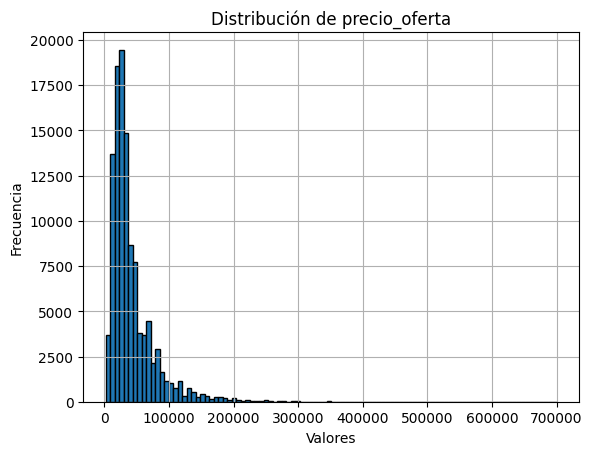

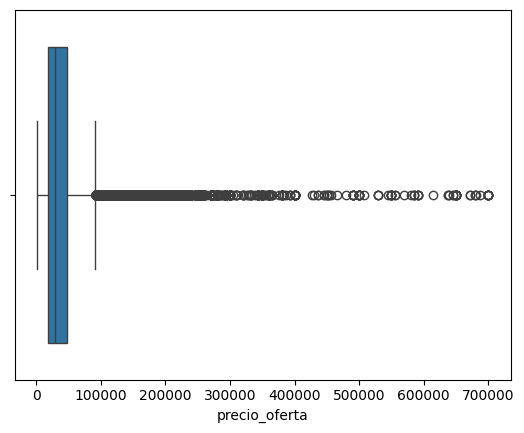

In [ ]:
# Histograma
df_CDMX['precio_oferta'].hist(bins=100, edgecolor='black')
plt.title('Distribución de precio_oferta')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot para detectar outliers
sns.boxplot(x=df['precio_oferta'])
plt.show()

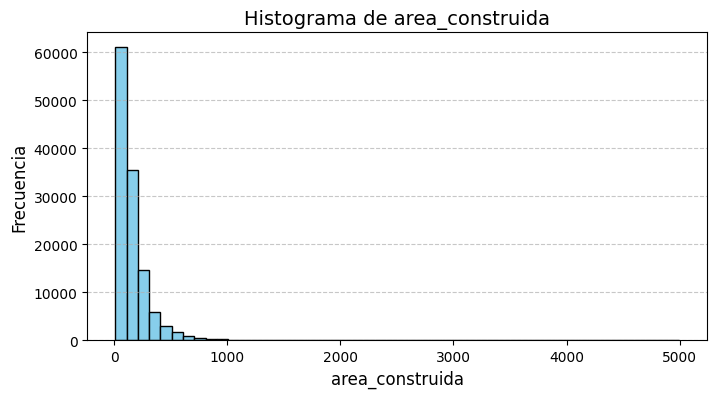

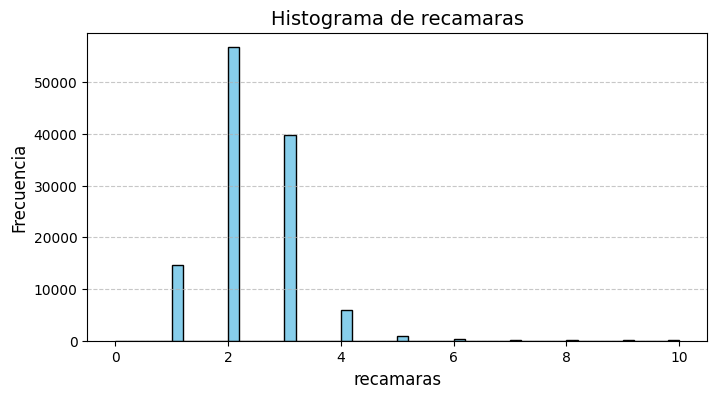

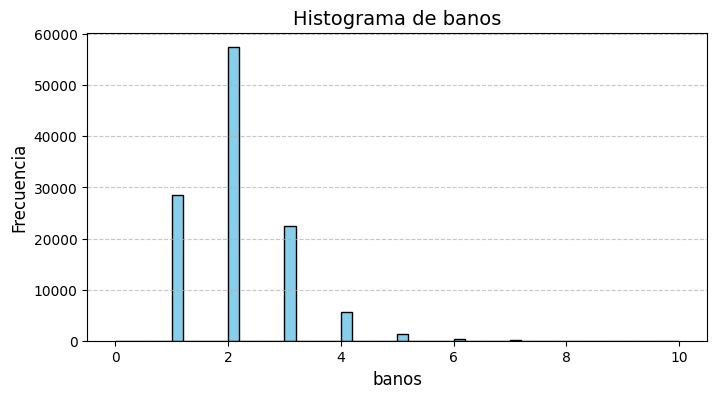

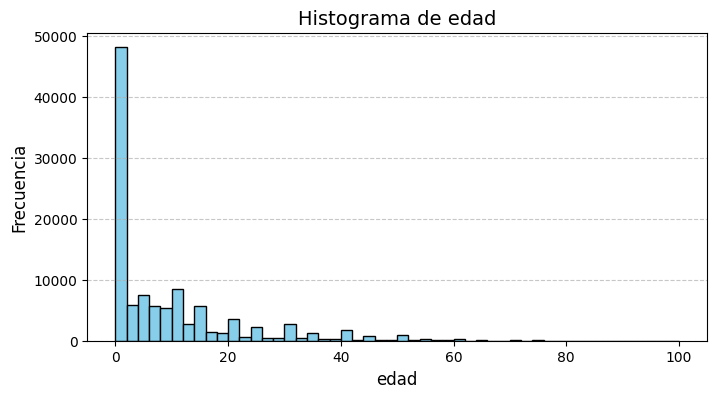

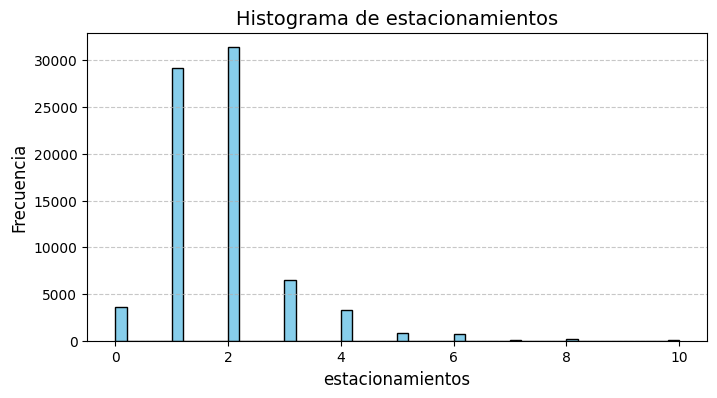

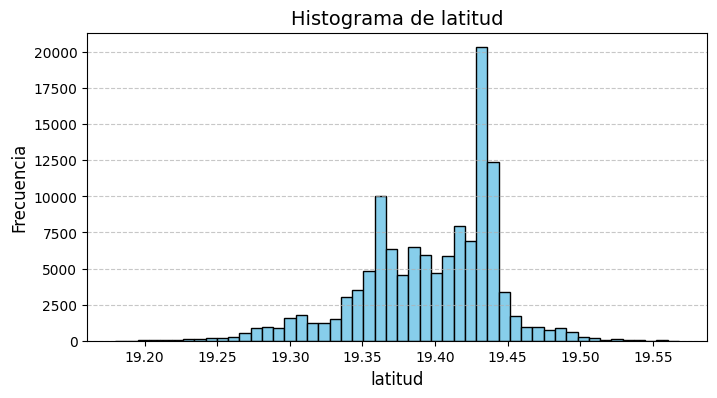

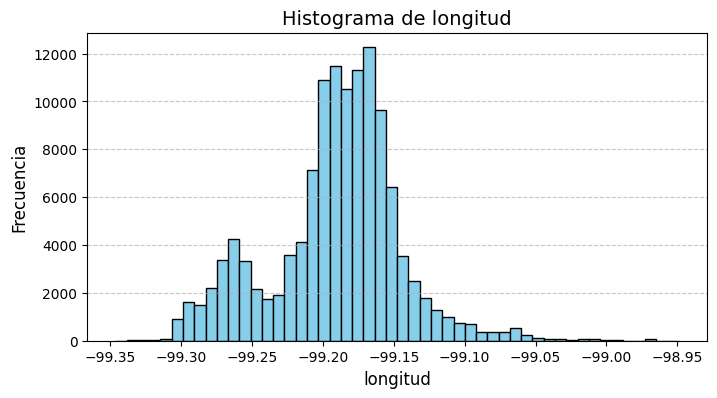

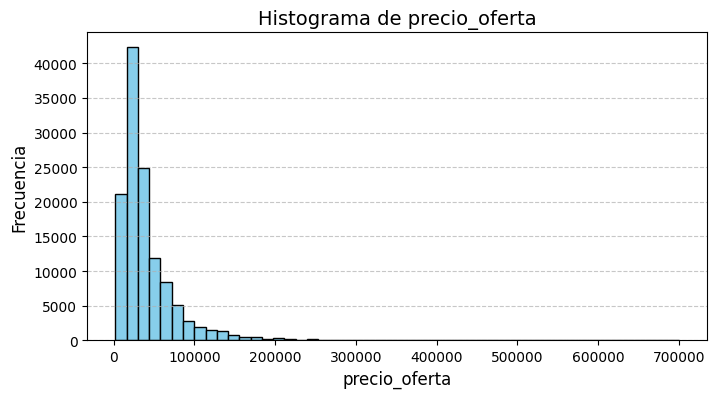

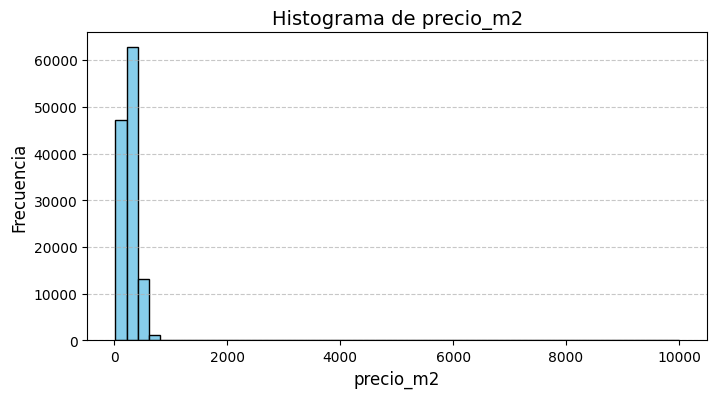

In [ ]:
# Identificar todas las columnas numéricas
numerical_columns = df_CDMX.select_dtypes(include=['float64', 'int64']).columns

# Generar histogramas para cada columna numérica
for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    plt.hist(df[col], bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Histograma de {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [ ]:
# Detectar outliers con IQR
Q1 = df_CDMX['precio_oferta'].quantile(0.25)
Q3 = df_CDMX['precio_oferta'].quantile(0.75)
IQR = Q3 - Q1

# Filtrar outliers
outliers = df_CDMX[(df_CDMX['precio_oferta'] < Q1 - 1.5 * IQR) | (df_CDMX['precio_oferta'] > Q3 + 1.5 * IQR)]
print(outliers)

       tipo_propiedad  area_construida  recamaras  banos  edad  \
11       Departamento            350.0          3      3     0   
17               Casa            587.0          6      0     0   
168              Casa            428.1          4      5     5   
211      Departamento            400.0          4      4    22   
223      Departamento            350.0          3      3     1   
...               ...              ...        ...    ...   ...   
124347   Departamento            400.0          4      4     2   
124371   Departamento            500.0          3      3     5   
124376   Departamento            340.0          4      2    10   
124386   Departamento            220.0          3      3     4   
124439   Departamento            290.0          3      3    15   

        estacionamientos    latitud   longitud              Municipio  \
11                     4  19.427831 -99.221820         Miguel Hidalgo   
17                     6  19.434535 -99.201117         Miguel

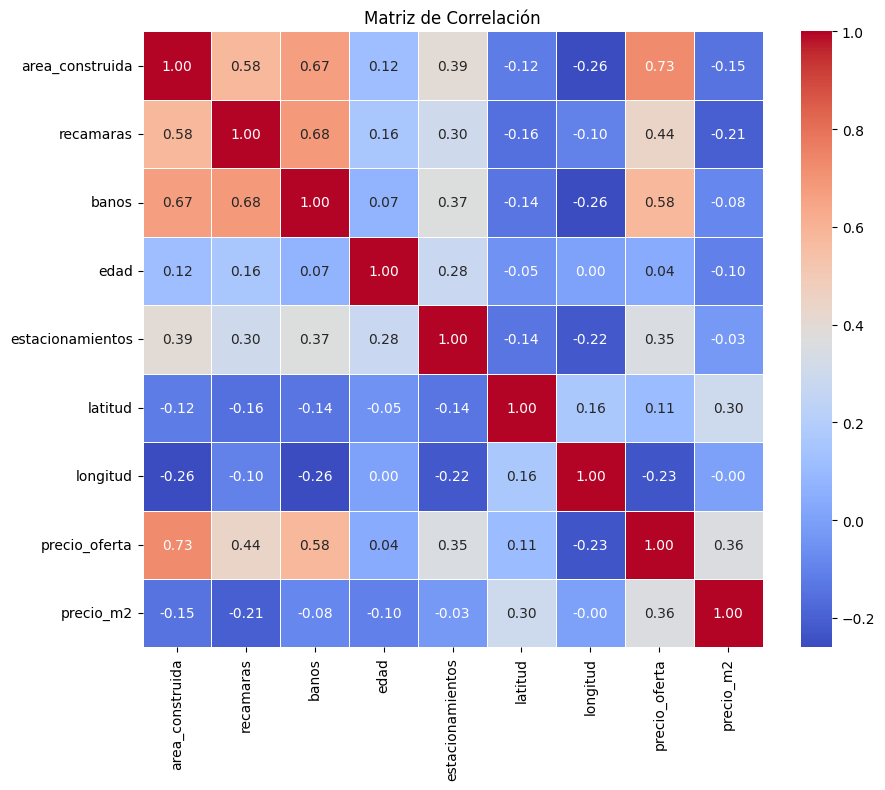

In [ ]:
# Seleccionar solo las columnas numéricas
df_numeric = df_CDMX.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación
correlation_matrix = df_numeric.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

In [ ]:
df_CDMX_sin_fecha = df_CDMX.drop(columns=['fecha_oferta'])

In [ ]:
df_CDMX_sin_fecha.head()

,tipo_propiedad,area_construida,recamaras,banos,edad,estacionamientos,latitud,longitud,Municipio,Colonia,precio_oferta,precio_m2,cp
0,Departamento,74.0,3,2,5,1,19.464082,-99.120232,Gustavo A. Madero,Guadalupe Tepeyac,16000.0,216.216216,7840.0
1,Departamento,200.0,3,3,7,3,19.382607,-99.161064,Benito Juárez,Del Valle Centro,55000.0,275.000000,3100.0
2,Departamento,74.0,3,1,0,0,19.508087,-99.136730,Gustavo A. Madero,Sierravista,11000.0,148.648649,7320.0
3,Departamento,45.0,1,1,0,0,19.475753,-99.175971,Azcapotzalco,Un Hogar Para Cada Trabajador,7600.0,168.888889,2060.0
4,Departamento,65.0,2,1,0,0,19.442391,-99.096380,Venustiano Carranza,Romero Rubio,11000.0,169.230769,15400.0


In [ ]:
scaler = MinMaxScaler()
columnas_continuas = ['area_construida', 'latitud', 'longitud', 'precio_oferta', 'precio_m2']
df_CDMX_sin_fecha[columnas_continuas] = scaler.fit_transform(df_CDMX_sin_fecha[columnas_continuas])

In [ ]:
# Convertir a enteros (si es posible)
df_CDMX_sin_fecha[['recamaras', 'banos', 'estacionamientos', 'edad']] = df_CDMX_sin_fecha[
    ['recamaras', 'banos', 'estacionamientos', 'edad']
].astype('int64')

# Convertir a tipo 'category' las variables que se codificarán
df_CDMX_sin_fecha[['recamaras', 'banos', 'estacionamientos']] = df_CDMX_sin_fecha[
    ['recamaras', 'banos', 'estacionamientos']
].astype('category')

In [ ]:
# Asegurar que todas las entradas sean strings
df_CDMX_sin_fecha['Colonia'] = df_CDMX_sin_fecha['Colonia'].astype(str)
df_CDMX_sin_fecha['cp'] = df_CDMX_sin_fecha['cp'].astype(str)

In [ ]:
# Crear un encoder para cada columna (evita conflictos)
encoder_colonia = LabelEncoder()
encoder_cp = LabelEncoder()

# Aplicar a cada columna por separado
df_CDMX_sin_fecha['Colonia_encoded'] = encoder_colonia.fit_transform(df_CDMX_sin_fecha['Colonia'])
df_CDMX_sin_fecha['cp_encoded'] = encoder_cp.fit_transform(df_CDMX_sin_fecha['cp'])

# Eliminar columnas originales
df_CDMX_sin_fecha = df_CDMX_sin_fecha.drop(columns=['Colonia', 'cp'])

In [ ]:
df_CDMX_sin_fecha.head()

,tipo_propiedad,area_construida,recamaras,banos,edad,estacionamientos,latitud,longitud,Municipio,precio_oferta,precio_m2,Colonia_encoded,cp_encoded
0,Departamento,0.012841,3,2,5,1,0.732241,0.568990,Gustavo A. Madero,0.020057,0.019661,401,801
1,Departamento,0.038122,3,3,7,3,0.522403,0.466310,Benito Juárez,0.075931,0.025551,263,517
2,Departamento,0.012841,3,1,0,0,0.845576,0.527504,Gustavo A. Madero,0.012894,0.012891,1056,749
3,Departamento,0.007022,1,1,0,0,0.762300,0.428824,Azcapotzalco,0.008023,0.014919,1145,452
4,Departamento,0.011035,2,1,0,0,0.676376,0.628971,Venustiano Carranza,0.012894,0.014953,882,314


In [ ]:
#Aplicar One Hot Encoding a las variables categóricas:

columnas_one_hot = [
    'tipo_propiedad', 
    'Municipio', 
    'recamaras', 
    'banos', 
    'estacionamientos'
]

df_final = pd.get_dummies(df_CDMX_sin_fecha, columns=columnas_one_hot)

In [ ]:
print(df_final.dtypes)

area_construida                     float64
edad                                  int64
latitud                             float64
longitud                            float64
precio_oferta                       float64
precio_m2                           float64
Colonia_encoded                       int64
cp_encoded                            int64
tipo_propiedad_Casa                    bool
tipo_propiedad_Departamento            bool
Municipio_Azcapotzalco                 bool
Municipio_Benito Juárez                bool
Municipio_Coyoacán                     bool
Municipio_Cuajimalpa de Morelos        bool
Municipio_Cuauhtémoc                   bool
Municipio_Gustavo A. Madero            bool
Municipio_Iztacalco                    bool
Municipio_Iztapalapa                   bool
Municipio_La Magdalena Contreras       bool
Municipio_Miguel Hidalgo               bool
Municipio_Milpa Alta                   bool
Municipio_Tlalpan                      bool
Municipio_Tláhuac               

In [ ]:
df_final.head()

,area_construida,edad,latitud,longitud,precio_oferta,precio_m2,Colonia_encoded,cp_encoded,tipo_propiedad_Casa,tipo_propiedad_Departamento,...,estacionamientos_1,estacionamientos_2,estacionamientos_3,estacionamientos_4,estacionamientos_5,estacionamientos_6,estacionamientos_7,estacionamientos_8,estacionamientos_9,estacionamientos_10
0,0.012841,5,0.732241,0.568990,0.020057,0.019661,401,801,False,True,...,True,False,False,False,False,False,False,False,False,False
1,0.038122,7,0.522403,0.466310,0.075931,0.025551,263,517,False,True,...,False,False,True,False,False,False,False,False,False,False
2,0.012841,0,0.845576,0.527504,0.012894,0.012891,1056,749,False,True,...,False,False,False,False,False,False,False,False,False,False
3,0.007022,0,0.762300,0.428824,0.008023,0.014919,1145,452,False,True,...,False,False,False,False,False,False,False,False,False,False
4,0.011035,0,0.676376,0.628971,0.012894,0.014953,882,314,False,True,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
print(df_final.columns)

Index(['area_construida', 'edad', 'latitud', 'longitud', 'precio_oferta',
       'precio_m2', 'Colonia_encoded', 'cp_encoded', 'tipo_propiedad_Casa',
       'tipo_propiedad_Departamento', 'Municipio_Azcapotzalco',
       'Municipio_Benito Juárez', 'Municipio_Coyoacán',
       'Municipio_Cuajimalpa de Morelos', 'Municipio_Cuauhtémoc',
       'Municipio_Gustavo A. Madero', 'Municipio_Iztacalco',
       'Municipio_Iztapalapa', 'Municipio_La Magdalena Contreras',
       'Municipio_Miguel Hidalgo', 'Municipio_Milpa Alta', 'Municipio_Tlalpan',
       'Municipio_Tláhuac', 'Municipio_Venustiano Carranza',
       'Municipio_Xochimilco', 'Municipio_Álvaro Obregón', 'recamaras_0',
       'recamaras_1', 'recamaras_2', 'recamaras_3', 'recamaras_4',
       'recamaras_5', 'recamaras_6', 'recamaras_7', 'recamaras_8',
       'recamaras_9', 'recamaras_10', 'banos_0', 'banos_1', 'banos_2',
       'banos_3', 'banos_4', 'banos_5', 'banos_6', 'banos_7', 'banos_8',
       'banos_9', 'banos_10', 'estacionamie

In [ ]:
df_CDMX_test = df_CDMX.drop(columns=['fecha_oferta'])
df_CDMX_test.head()

,tipo_propiedad,area_construida,recamaras,banos,edad,estacionamientos,latitud,longitud,Municipio,Colonia,precio_oferta,precio_m2,cp
0,Departamento,74.0,3,2,5,1,19.464082,-99.120232,Gustavo A. Madero,Guadalupe Tepeyac,16000.0,216.216216,7840.0
1,Departamento,200.0,3,3,7,3,19.382607,-99.161064,Benito Juárez,Del Valle Centro,55000.0,275.000000,3100.0
2,Departamento,74.0,3,1,0,0,19.508087,-99.136730,Gustavo A. Madero,Sierravista,11000.0,148.648649,7320.0
3,Departamento,45.0,1,1,0,0,19.475753,-99.175971,Azcapotzalco,Un Hogar Para Cada Trabajador,7600.0,168.888889,2060.0
4,Departamento,65.0,2,1,0,0,19.442391,-99.096380,Venustiano Carranza,Romero Rubio,11000.0,169.230769,15400.0


In [ ]:
df_CDMX_test.columns

Index(['tipo_propiedad', 'area_construida', 'recamaras', 'banos', 'edad',
       'estacionamientos', 'latitud', 'longitud', 'Municipio', 'Colonia',
       'precio_oferta', 'precio_m2', 'cp'],
      dtype='object')

## Enfoque 1

Este código implementa un TabTransformer para la generación de datos sintéticos en real estate, incluyendo preprocesamiento, entrenamiento y generación de muestras.

La función preprocess_data(df):

- Convierte las columnas Colonia y cp a string.

- Aplica transformaciones diferentes según el tipo de variable:

    - Escalado Min-Max para variables numéricas.

    - Codificación Ordinal para variables categóricas con jerarquía (Colonia y cp).

    - One-Hot Encoding para otras categóricas (tipo_propiedad, Municipio, recamaras, etc.).

- Usa Pipeline para facilitar el preprocesamiento y obtener metadatos útiles.

Posibles mejoras:

- OrdinalEncoder asigna valores arbitrarios; si hay jerarquía, se debería definir manualmente.

- OneHotEncoder puede consumir más memoria con muchas categorías.


La clase TabTransformer:

- Usa embeddings para las variables categóricas.
- Proyecta variables numéricas a un espacio de embedding.
- Pasa los embeddings a una capa TransformerEncoder.
- Genera predicciones para variables numéricas (MSELoss) y categóricas (Sigmoid o Softmax).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder

# 1. Preprocesamiento mejorado
def preprocess_data(df):
    df = df.copy()
    df[['Colonia', 'cp']] = df[['Colonia', 'cp']].astype(str)
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('minmax', MinMaxScaler(), ['area_construida', 'latitud', 'longitud', 'precio_oferta', 'precio_m2']),
            ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['Colonia', 'cp']),
            ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore', categories='auto'), 
             ['tipo_propiedad', 'Municipio', 'recamaras', 'banos', 'estacionamientos'])
        ],
        remainder='drop'
    )
    
    pipeline = Pipeline([('preprocessor', preprocessor)])
    df_transformed_np = pipeline.fit_transform(df)
    
    # Obtener metadatos
    numerical_cols = preprocessor.transformers_[0][2]
    ordinal_cols = preprocessor.transformers_[1][2]
    onehot_cols = preprocessor.transformers_[2][2]
    categories = preprocessor.transformers_[2][1].categories_
    
    # Calcular valores únicos para ordinales
    ordinal_unique = {col: len(df[col].unique()) for col in ordinal_cols}
    
    return (
        pd.DataFrame(df_transformed_np, columns=preprocessor.get_feature_names_out()),
        pipeline,
        {
            'numerical_cols': numerical_cols,
            'ordinal_cols': ordinal_cols,
            'ordinal_unique': ordinal_unique,
            'onehot_cols': onehot_cols,
            'categories': categories,
            'original_columns': df.columns.tolist()
        }
    )

# 2. Modelo TabTransformer corregido
class TabTransformer(nn.Module):
    def __init__(self, input_dim, metadata, embed_dim=128, num_heads=4, num_layers=3):
        super(TabTransformer, self).__init__()
        self.metadata = metadata
        self.embed_dim = embed_dim
        
        # Embeddings para características categóricas
        self.embeddings = nn.ModuleDict()
        for col in metadata['ordinal_cols'] + metadata['onehot_cols']:
            if col in metadata['ordinal_cols']:
                unique_vals = metadata['ordinal_unique'][col]
            else:
                cat_idx = metadata['onehot_cols'].index(col)
                unique_vals = len(metadata['categories'][cat_idx])
                
            self.embeddings[col] = nn.Embedding(unique_vals, embed_dim)
        
        # Proyección para características numéricas
        self.num_numerical = len(metadata['numerical_cols'])
        self.numerical_proj = nn.Linear(self.num_numerical, embed_dim)
        
        # Capa Transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Decoders
        self.num_decoder = nn.Sequential(
            nn.Linear(embed_dim, self.num_numerical),
            nn.Sigmoid()
        )
        
        self.cat_decoders = nn.ModuleDict()
        for col in metadata['ordinal_cols']:
            self.cat_decoders[col] = nn.Sequential(
                nn.Linear(embed_dim, 1),
                nn.Sigmoid()
            )
            
        for col, cats in zip(metadata['onehot_cols'], metadata['categories']):
            self.cat_decoders[col] = nn.Sequential(
                nn.Linear(embed_dim, len(cats)),
                nn.Softmax(dim=1)
            )

    def forward(self, x):
        # Procesar características numéricas
        numerical = x[:, :self.num_numerical]
        num_embed = self.numerical_proj(numerical)
        
        # Procesar características categóricas
        cat_embeds = []
        for i, col in enumerate(self.metadata['ordinal_cols'] + self.metadata['onehot_cols']):
            col_idx = self.num_numerical + i
            values = x[:, col_idx].long().clamp(min=0)
            embed = self.embeddings[col](values)
            cat_embeds.append(embed)
        
        # Combinar embeddings
        all_embeds = torch.cat([num_embed.unsqueeze(1)] + [e.unsqueeze(1) for e in cat_embeds], dim=1)
        
        # Transformer
        transformer_out = self.transformer(all_embeds)
        
        # Decodificar
        numerical_out = self.num_decoder(transformer_out.mean(dim=1))
        
        cat_outputs = []
        for col in self.metadata['ordinal_cols'] + self.metadata['onehot_cols']:
            col_idx = 1 + (self.metadata['ordinal_cols'] + self.metadata['onehot_cols']).index(col)
            decoder = self.cat_decoders[col]
            cat_outputs.append(decoder(transformer_out[:, col_idx, :]))
        
        return torch.cat([numerical_out] + cat_outputs, dim=1)

# 3. Función de pérdida mejorada
def custom_loss(output, target, metadata):
    # Pérdida para características numéricas
    numerical_loss = nn.MSELoss()(output[:, :len(metadata['numerical_cols'])], 
                                 target[:, :len(metadata['numerical_cols'])])
    
    cat_loss = 0
    current_idx = len(metadata['numerical_cols'])
    
    # Pérdida para ordinales
    for col in metadata['ordinal_cols']:
        target_values = target[:, current_idx]
        pred_values = output[:, current_idx]
        cat_loss += nn.MSELoss()(pred_values, target_values)
        current_idx += 1
    
    # Pérdida para one-hot
    for col, cats in zip(metadata['onehot_cols'], metadata['categories']):
        n_cats = len(cats)
        target_labels = target[:, current_idx:current_idx+n_cats].argmax(dim=1)
        cat_loss += nn.CrossEntropyLoss()(output[:, current_idx:current_idx+n_cats], target_labels)
        current_idx += n_cats
    
    return numerical_loss + 0.5 * cat_loss

# 4. Generación de muestras corregida
def generate_samples(model, metadata, pipeline, device, n_samples=5):
    with torch.no_grad():
        # Generar ruido controlado
        noise_numerical = torch.randn(n_samples, model.num_numerical).to(device)
        
        noise_cat = []
        for col in metadata['ordinal_cols'] + metadata['onehot_cols']:
            if col in metadata['ordinal_cols']:
                max_val = model.embeddings[col].num_embeddings - 1
            else:
                max_val = len(metadata['categories'][metadata['onehot_cols'].index(col)]) - 1
                
            indices = torch.randint(0, max_val + 1, (n_samples,)).float()
            noise_cat.append(indices)
        
        noise_cat = torch.stack(noise_cat, dim=1).to(device)
        noise = torch.cat([noise_numerical, noise_cat], dim=1)
        
        samples = model(noise).cpu().numpy()
    
    # Crear DataFrame transformado
    synthetic_df = pd.DataFrame(samples, columns=metadata['transformed_columns'])
    synthetic_original = pd.DataFrame(index=range(n_samples), columns=metadata['original_columns'])
    
    # Transformación inversa numérica
    if metadata['numerical_cols']:
        num_cols = [f'minmax__{col}' for col in metadata['numerical_cols']]
        num_data = synthetic_df[num_cols].values
        synthetic_original[metadata['numerical_cols']] = pipeline.named_steps['preprocessor'].transformers_[0][1].inverse_transform(num_data)
    
    # Transformación inversa ordinal (corregida)
    if metadata['ordinal_cols']:
        ordinal_cols = [f'ordinal__{col}' for col in metadata['ordinal_cols']]
        ordinal_data = synthetic_df[ordinal_cols].values
        inverse_ordinal = pipeline.named_steps['preprocessor'].transformers_[1][1].inverse_transform(ordinal_data)
        for i, col in enumerate(metadata['ordinal_cols']):
            synthetic_original[col] = inverse_ordinal[:, i].astype(str)
    
    # Transformación inversa one-hot
    for col, cats in zip(metadata['onehot_cols'], metadata['categories']):
        onehot_cols = [f'onehot__{col}_{cat}' for cat in cats]
        onehot_data = synthetic_df[onehot_cols].values
        synthetic_original[col] = [cats[np.argmax(vec)] for vec in onehot_data]
    
    # Post-procesamiento final
    for col in metadata['original_columns']:
        if col in metadata['numerical_cols']:
            synthetic_original[col] = pd.to_numeric(synthetic_original[col], errors='coerce').fillna(0)
        else:
            synthetic_original[col] = synthetic_original[col].astype(str)
    
    print("\nMuestras sintéticas generadas:")
    print(synthetic_original)
    return synthetic_original

# 5. Entrenamiento optimizado
def train_model(df_transformed, metadata, pipeline, epochs=500, batch_size=64):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    metadata['transformed_columns'] = df_transformed.columns.tolist()
    
    data = torch.tensor(df_transformed.values, dtype=torch.float32).to(device)
    dataloader = DataLoader(TensorDataset(data), batch_size=batch_size, shuffle=True)
    
    model = TabTransformer(df_transformed.shape[1], metadata).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5)
    
    for epoch in range(1, epochs+1):
        print(f"epoca:{epoch}")
        model.train()
        total_loss = 0
        for batch in dataloader:
            x = batch[0]
            optimizer.zero_grad()
            output = model(x)
            loss = custom_loss(output, x, metadata)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()
        
        scheduler.step(total_loss)
        
        if epoch % 50 == 0 or epoch == 1:
            print(f'\nEpoch {epoch}, Loss: {total_loss/len(dataloader):.4f}')
            model.eval()
            generate_samples(model, metadata, pipeline, device)
    
    return model

# --- Ejecución principal ---
if __name__ == "__main__":
    # Cargar datos (ejemplo)
    data = {
        'area_construida': [120, 80, 150],
        'latitud': [19.4326, 19.3325, 19.4826],
        'longitud': [-99.1332, -99.1456, -99.1234],
        'precio_oferta': [5000000, 3500000, 6500000],
        'precio_m2': [41666, 43750, 43333],
        'tipo_propiedad': ['Casa', 'Departamento', 'Oficina'],
        'Municipio': ['Cuauhtémoc', 'Benito Juárez', 'Miguel Hidalgo'],
        'recamaras': [3, 2, 4],
        'banos': [2, 1, 3],
        'estacionamientos': [2, 1, 3],
        'Colonia': ['Roma', 'Del Valle', 'Polanco'],
        'cp': ['06700', '03100', '11560']
    }
    # df_CDMX_test_2 = pd.DataFrame(data)
    
    # Preprocesamiento
    df_transformed, pipeline, metadata = preprocess_data(df_CDMX_test)
    
    # Entrenamiento
    model = train_model(df_transformed, metadata, pipeline, epochs=500)
    
    # Guardar modelo
    torch.save(model.state_dict(), "tabtransformer_final.pth")

epoca:1

Epoch 1, Loss: 330984.8029

Muestras sintéticas generadas:
  tipo_propiedad  area_construida recamaras banos edad estacionamientos  \
0   Departamento        72.699554         2     2  nan                0   
1           Casa       117.833252         2     3  nan                0   
2   Departamento        79.255676         2     2  nan                0   
3   Departamento        92.402214         2     2  nan                0   
4   Departamento        59.301357         2     2  nan                0   

     latitud   longitud       Municipio Colonia  precio_oferta   precio_m2  \
0  19.444286 -99.149078  Miguel Hidalgo       0   23034.667969  215.715179   
1  19.348896 -99.184402  Miguel Hidalgo       0   29494.869141  205.283249   
2  19.406216 -99.191284  Miguel Hidalgo       0   21132.638672  125.100304   
3  19.374163 -99.204475  Miguel Hidalgo       0   25915.316406  107.995651   
4  19.375446 -99.184219  Miguel Hidalgo       0   13845.402344  133.627548   

    cp  
0  

KeyboardInterrupt: 

#### Conclusiones

1. La pérdida (Loss) no parece mejorar

Epoch 1: 330984.80

Epoch 50: 330972.47

Epoch 100: 330972.71

Epoch 150: 330985.08

La pérdida prácticamente no ha cambiado en 150 épocas, lo que sugiere que el modelo no está aprendiendo o ya alcanzó su mínimo muy temprano.

2. Datos sintéticos tienen inconsistencias

Columna "edad" con valores nan → Puede indicar que el modelo no está generando valores realistas en esa variable.

CP es 0 o 1000 → No hay suficiente variabilidad en estos valores, lo cual puede ser problemático si en los datos reales hay más diversidad.

Precios de oferta y precio por m² tienen valores extremos → Algunos precios parecen excesivamente altos (ej. 340,787 por 107m²) y otros inusualmente bajos.

3. Área construida y estacionamientos varían mucho

Algunas muestras parecen poco realistas, como departamentos de más de 1,000 m².

"Estacionamientos" es casi siempre 0, lo que puede ser un sesgo del modelo.

#### Problemas de las redes neuronales frente a transformers

- Complejidad y overfitting: Las redes neuronales complejas tienen un mayor riesgo de sobreajuste, lo que impide su capacidad de generalizar correctamente. En los resultados, la pérdida se mantiene prácticamente constante, lo que sugiere que el modelo podría estar atascado en un mínimo subóptimo.

- Pérdida de memoria en redes recurrentes: Las arquitecturas recurrentes, utilizadas en algunas GANs, presentan dificultades para retener información a largo plazo debido al desvanecimiento del gradiente, lo que limita su capacidad de aprendizaje en datos tabulares.

- Tiempos de entrenamiento elevados en GANs: El proceso de entrenamiento de las GANs es largo y poco estable, ya que requiere optimizar simultáneamente el generador y el discriminador.

- Resultados inconsistentes: En las muestras sintéticas generadas se observan valores nan, así como rangos extremos en variables como área construida y precio por metro cuadrado, lo que indica que el modelo aún no logra capturar correctamente la distribución de los datos originales.

## Enfoque 2

Este código constituye un pipeline integral para abordar los problemas identificados en el primer enfoque, especialmente para solventar inconsistencias en la información de localización (como discrepancias entre latitud, longitud, colonia y municipio). Para ello, se optó por un nuevo enfoque que incorpora el cálculo de polígonos, permitiendo validar la coherencia geográfica de las predicciones del modelo. A continuación se detalla y resume cada componente del código:

- Preprocesamiento y normalización
    - Escalador personalizado (GeoScaler): Se implementa una clase que normaliza los datos numéricos mediante  (X−mean)/std y que permite revertir esta transformación, facilitando la interpretación de las predicciones.
    - Transformaciones:
        - Las variables numéricas se escalan usando el GeoScaler.
        - Las variables categóricas (como tipo de propiedad y municipio) y las cadenas (por ejemplo, colonia) se transforman usando codificación ordinal.
- Metadata: Se recopila información de categorías, escaladores y mapeos (como la relación entre código postal y municipio) para su uso posterior en el modelo.

- Cálculo de polígonos:
Se crean funciones que generan un GeoDataFrame a partir de las coordenadas y, para cada municipio, se calcula su envolvente convexa (convex hull). Esto permite:
    - Validar que las predicciones geográficas (latitud y longitud) se encuentren dentro de los polígonos correspondientes al municipio.
    - Asignar penalizaciones en la función de pérdida si las coordenadas predichas se alejan del área real del municipio.

In [ ]:
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# ---------------------------
# 1) Escalador personalizado
# ---------------------------
class GeoScaler(BaseEstimator, TransformerMixin):
    """Escala con (X - mean) / std y permite inverse_transform"""
    def __init__(self):
        self.means_ = None
        self.stds_ = None
        
    def fit(self, X, y=None):
        self.means_ = X.mean(axis=0)
        self.stds_ = X.std(axis=0)
        return self
    
    def transform(self, X):
        return (X - self.means_) / self.stds_
    
    def inverse_transform(self, X):
        return X * self.stds_ + self.means_


# ---------------------------
# 2) Preprocesamiento de datos
# ---------------------------
def preprocess_data(df):
    df = df.copy()
    
    # Verificar columnas requeridas
    required_cols = [
        'tipo_propiedad', 'area_construida', 'recamaras', 'banos', 'edad',
        'estacionamientos', 'latitud', 'longitud', 'Municipio', 'Colonia',
        'precio_oferta', 'precio_m2', 'cp'
    ]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Falta la columna {col} en tu DataFrame.")
    
    # Filtrar CP inválidos y valores faltantes
    df = df.dropna(subset=['cp', 'Municipio'])
    valid_cp_mask = df['cp'].apply(lambda x: x.isdigit() and len(x) == 5 and x != '00000')
    df = df[valid_cp_mask].reset_index(drop=True)
    
    # Definir columnas:
    numerical_features = [
        'area_construida', 'recamaras', 'banos', 'edad', 'estacionamientos',
        'latitud', 'longitud', 'precio_oferta', 'precio_m2'
    ]
    categorical_features = ['tipo_propiedad', 'Municipio']  # Se procesan con OrdinalEncoder
    # Sólo "Colonia" se procesa con OrdinalEncoder; "cp" se tratará por separado para usar embeddings.
    string_features = ['Colonia']
    
    # Construir ColumnTransformer para numérico, categórico y Colonia
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', GeoScaler(), numerical_features),
            ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=-1), categorical_features),
            ('str', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=-1), string_features),
        ],
        remainder='drop'
    )
    
    df_transformed = preprocessor.fit_transform(df)
    
    # Extraer categorías
    cat_encoder = preprocessor.named_transformers_['cat']
    str_encoder = preprocessor.named_transformers_['str']
    prop_categories = [str(c) for c in cat_encoder.categories_[0]]
    mun_categories  = [str(c) for c in cat_encoder.categories_[1]]
    col_categories  = [str(c) for c in str_encoder.categories_[0]]
    
    # Procesar CP usando Pandas para obtener códigos (esto se usará para el embedding)
    df['cp_code'] = df['cp'].astype('category').cat.codes
    cp_categories = list(df['cp'].astype('category').cat.categories)
    
    # Armar metadata
    metadata = {
        'numerical': numerical_features,
        'categorical': categorical_features,
        'string': string_features,
        'preprocessor': preprocessor,
        'prop_categories': prop_categories,
        'mun_categories': mun_categories,
        'cp_categories': cp_categories,
        'col_categories': col_categories,
        'cp_to_mun': df.groupby('cp')['Municipio'].first().to_dict(),
        'cp_freq': df['cp'].value_counts(normalize=True).to_dict()
    }
    
    # Crear DataFrame final: usar columnas transformadas y añadir la columna cp
    cols = numerical_features + categorical_features + string_features
    df_out = pd.DataFrame(df_transformed, columns=cols)
    df_out['cp'] = df['cp_code'].values
    # Reordenar: numéricas (0..8), 9: tipo_propiedad, 10: Municipio, 11: cp, 12: Colonia
    df_out = df_out[numerical_features + categorical_features + ['cp'] + string_features]
    return df_out, metadata


# ----------------------------------------------------
# Funciones para obtener polígonos de municipios
# ----------------------------------------------------
def compute_municipality_polygons(df):
    """
    Crea un GeoDataFrame y calcula el convex hull para cada municipio.
    Retorna un diccionario que mapea el nombre del municipio al polígono resultante.
    """
    geometry = [Point(lon, lat) for lon, lat in zip(df['longitud'], df['latitud'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry)
    polygons = gdf.groupby('Municipio')['geometry'].apply(lambda x: x.unary_union.convex_hull)
    return polygons.to_dict()

def map_municipality_polygons(polygons, metadata):
    """
    Mapea el diccionario de polígonos (clave: nombre de municipio) a un diccionario
    usando como clave el índice según metadata['mun_categories'].
    """
    mun_poly = {}
    for idx, mun in enumerate(metadata['mun_categories']):
        mun_poly[idx] = polygons.get(mun, None)
    return mun_poly


# ----------------------------------------------------
# Clase para ReLU+epsilon
# ----------------------------------------------------
class ReLUEpsilon(nn.Module):
    def __init__(self, epsilon=1e-6):
        super().__init__()
        self.epsilon = epsilon
    def forward(self, x):
        return torch.relu(x) + self.epsilon


# --------------------------------------------
# 3) Modelo TabTransformer con *todas* las "heads"
# --------------------------------------------

# Decodificador personalizado para "house specs"
class HouseSpecsDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        # Usar ReLU+epsilon para área, recámaras y baños
        self.strict_positive = nn.Sequential(
            nn.Linear(hidden_dim, 3),
            ReLUEpsilon(epsilon=1e-6)
        )
        # Para edad y estacionamientos, se usa ReLU (pueden ser 0)
        self.non_negative = nn.Sequential(
            nn.Linear(hidden_dim, 2),
            nn.ReLU()
        )
        
    def forward(self, x):
        shared_out = self.shared(x)
        out_strict = self.strict_positive(shared_out)
        out_nonneg = self.non_negative(shared_out)
        # Orden final: [área, recámaras, baños, edad, estacionamientos]
        return torch.cat([out_strict, out_nonneg], dim=1)


class GeoAwareTabTransformer(nn.Module):
    def __init__(self, metadata, embed_dim=64):
        super().__init__()
        
        self.embed_dim = embed_dim
        self.num_numerical = len(metadata['numerical'])
        
        self.prop_vocab_size = len(metadata['prop_categories']) + 1
        self.mun_vocab_size  = len(metadata['mun_categories']) + 1
        self.cp_vocab_size   = len(metadata['cp_categories']) + 1  # Usamos los CP procesados
        
        self.prop_embed = nn.Embedding(self.prop_vocab_size, embed_dim, padding_idx=0)
        self.mun_embed  = nn.Embedding(self.mun_vocab_size, embed_dim, padding_idx=0)
        self.cp_embed   = nn.Embedding(self.cp_vocab_size, embed_dim, padding_idx=0)
        
        self.num_proj = nn.Linear(self.num_numerical, embed_dim * 3)
        
        self.cat_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embed_dim * 3,
                nhead=3,
                dim_feedforward=256,
                batch_first=True
            ),
            num_layers=2
        )
        
        self.feature_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embed_dim * 6,
                nhead=6,
                dim_feedforward=512,
                batch_first=True
            ),
            num_layers=2
        )
        
        self.price_decoder = nn.Sequential(
            nn.Linear(embed_dim * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 2),
            nn.Softplus()
        )
        
        self.geo_decoder = nn.Sequential(
            nn.Linear(embed_dim * 3, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2)
        )
        
        self.mun_classifier = nn.Linear(embed_dim * 3, self.mun_vocab_size)
        self.cp_classifier = nn.Linear(embed_dim * 3, self.cp_vocab_size)
        self.house_specs_decoder = HouseSpecsDecoder(input_dim=embed_dim * 6, hidden_dim=128)

    def forward(self, x):
        """
        x => [ num(9) | cat(2): (tipo_prop, Municipio) | cp (1) | str(1): (Colonia) ]
        Orden: columnas 0..8 = numéricas, 9 = tipo_propiedad, 10 = Municipio, 11 = cp, 12 = Colonia
        """
        x_num = x[:, :9]
        prop_indices = torch.clamp(x[:, 9].long() + 1, 0, self.prop_vocab_size - 1)
        mun_indices  = torch.clamp(x[:, 10].long() + 1, 0, self.mun_vocab_size - 1)
        cp_indices   = torch.clamp(x[:, 11].long() + 1, 0, self.cp_vocab_size - 1)
        
        prop_emb = self.prop_embed(prop_indices)
        mun_emb  = self.mun_embed(mun_indices)
        cp_emb   = self.cp_embed(cp_indices)
        
        cat_emb = torch.cat([prop_emb, mun_emb, cp_emb], dim=1)
        cat_context = self.cat_transformer(cat_emb.unsqueeze(1)).squeeze(1)
        
        num_proj = self.num_proj(x_num)
        combined = torch.cat([cat_context, num_proj], dim=1)
        features = self.feature_transformer(combined.unsqueeze(1)).squeeze(1)
        
        price_out = self.price_decoder(features)
        geo_out   = self.geo_decoder(cat_context)
        mun_logits = self.mun_classifier(cat_context)
        cp_logits  = self.cp_classifier(cat_context)
        house_specs_out = self.house_specs_decoder(features)
        
        return torch.cat([
            price_out,
            geo_out,
            mun_logits,
            cp_logits,
            house_specs_out,
            features
        ], dim=1)


# ----------------------------------------------------
# Función de consistency loss basada en proximidad promedio
# ----------------------------------------------------
def consistency_loss(outputs, metadata):
    """
    Calcula la distancia promedio para las muestras cuya coordenada predicha (geo_out)
    se encuentra fuera del polígono correspondiente al municipio predicho.
    Si el punto está dentro, se toma 0.
    """
    geo = outputs[:, 2:4]
    mun_logits_start = 4
    mun_vocab_size = len(metadata['mun_categories']) + 1
    mun_logits = outputs[:, mun_logits_start:mun_logits_start + mun_vocab_size]
    mun_pred = torch.argmax(mun_logits, dim=1)
    
    distances = []
    n = geo.shape[0]
    for i in range(n):
        point = Point(geo[i, 0].item(), geo[i, 1].item())
        poly = metadata.get('mun_polygons', {}).get(mun_pred[i].item(), None)
        if poly is None:
            distances.append(100.0)  # Si no hay polígono, asignamos una penalización alta
        else:
            if poly.contains(point):
                distances.append(0.0)
            else:
                d = poly.exterior.distance(point)
                distances.append(d)
    avg_distance = np.mean(distances)
    avg_distance = (avg_distance - 101) * 10
    return torch.tensor(avg_distance, device=outputs.device, dtype=geo.dtype)


# ----------------------------------------------------
# Función de pérdida global (GeoLoss)
# ----------------------------------------------------
class GeoLoss(nn.Module):
    def __init__(self, metadata, alpha_mun=0.5, alpha_cp=0.5, alpha_specs=1.5, lambda_consistency=0.1):
        """
        lambda_consistency = peso de la pérdida de consistencia (basada en proximidad promedio)
        Se aumenta alpha_specs para incrementar la contribución de house_specs.
        """
        super().__init__()
        self.mse = nn.MSELoss()
        self.cross_entropy = nn.CrossEntropyLoss()
        
        self.cp_to_mun = metadata['cp_to_mun']
        self.mun_categories = metadata['mun_categories']
        self.cp_categories  = metadata['cp_categories']
        
        self.mun_vocab_size = len(self.mun_categories) + 1
        self.cp_vocab_size  = len(self.cp_categories) + 1
        
        self.alpha_mun = alpha_mun
        self.alpha_cp = alpha_cp
        self.alpha_specs = alpha_specs
        self.lambda_consistency = lambda_consistency
    
    def forward(self, outputs, inputs):
        valid_mask = (inputs[:, 10] >= 0) & (inputs[:, 11] >= 0)
        if not valid_mask.any():
            return torch.tensor(0.0, device=outputs.device), {}
        
        valid_in = inputs[valid_mask]
        valid_out = outputs[valid_mask]
        
        price_loss = self.mse(valid_out[:, :2], valid_in[:, 7:9])
        geo_loss = self.mse(valid_out[:, 2:4], valid_in[:, 5:7])
        
        mun_logits_start = 4
        mun_logits_end = 4 + self.mun_vocab_size
        mun_logits = valid_out[:, mun_logits_start:mun_logits_end]
        cp_indices = valid_in[:, 11].long().cpu().numpy()
        cp_list = [self.cp_categories[i] if i < len(self.cp_categories) else '00000' for i in cp_indices]
        mun_targets = []
        for cp_str in cp_list:
            if cp_str in self.cp_to_mun and self.cp_to_mun[cp_str] in self.mun_categories:
                idx = self.mun_categories.index(self.cp_to_mun[cp_str])
                mun_targets.append(idx)
            else:
                mun_targets.append(0)
        mun_target_tensor = torch.tensor(mun_targets, device=outputs.device)
        mun_loss = self.cross_entropy(mun_logits, mun_target_tensor)
        
        cp_logits_start = mun_logits_end
        cp_logits_end = cp_logits_start + self.cp_vocab_size
        cp_logits = valid_out[:, cp_logits_start:cp_logits_end]
        cp_target_tensor = torch.clamp(valid_in[:, 11].long(), 0, self.cp_vocab_size - 1)
        cp_loss = self.cross_entropy(cp_logits, cp_target_tensor)
        
        house_specs_start = cp_logits_end
        house_specs_end = house_specs_start + 5
        house_specs_out = valid_out[:, house_specs_start:house_specs_end]
        specs_loss = self.mse(house_specs_out, valid_in[:, 0:5])
        
        cons_loss = consistency_loss(valid_out, metadata)
        
        total_loss = price_loss + geo_loss + self.alpha_mun * mun_loss + self.alpha_cp * cp_loss + self.alpha_specs * specs_loss + self.lambda_consistency * cons_loss
        
        losses = {
            'price_loss': price_loss,
            'geo_loss': geo_loss,
            'mun_loss': mun_loss,
            'cp_loss': cp_loss,
            'specs_loss': specs_loss,
            'consistency_loss': cons_loss,
            'total_loss': total_loss
        }
        return total_loss, losses


# ----------------------------------------------------
# Función para generar muestras sintéticas (cada 10 epochs)
# ----------------------------------------------------
def generate_geo_samples(model, metadata, n_samples=5):
    """
    Genera muestras sintéticas e incluye:
      - precio_oferta, precio_m2
      - latitud, longitud
      - Municipio, cp
      - área, recámaras, baños, edad, estacionamientos
    """
    model.eval()
    with torch.no_grad():
        prop_vocab_size = len(metadata['prop_categories']) + 1
        mun_vocab_size  = len(metadata['mun_categories']) + 1
        cp_vocab_size   = len(metadata['cp_categories']) + 1
        
        synthetic_in = torch.randn(n_samples, 13, device=device)
        synthetic_in[:, 9]  = torch.randint(0, prop_vocab_size, (n_samples,), device=device)
        synthetic_in[:, 10] = torch.randint(0, mun_vocab_size, (n_samples,), device=device)
        synthetic_in[:, 11] = torch.randint(0, cp_vocab_size, (n_samples,), device=device)
        synthetic_in[:, 12] = 0
        
        out = model(synthetic_in)
        out_np = out.cpu().numpy()
        
        precio_oferta = out_np[:, 0]
        precio_m2     = out_np[:, 1]
        latitud       = out_np[:, 2]
        longitud      = out_np[:, 3]
        
        mun_logits_start = 4
        mun_logits_end = 4 + len(metadata['mun_categories']) + 1
        mun_logits = out_np[:, mun_logits_start:mun_logits_end]
        mun_pred = np.argmax(mun_logits, axis=1)
        
        cp_logits_start = mun_logits_end
        cp_logits_end = cp_logits_start + len(metadata['cp_categories']) + 1
        cp_logits = out_np[:, cp_logits_start:cp_logits_end]
        cp_pred = np.argmax(cp_logits, axis=1)
        
        house_specs_start = cp_logits_end
        house_specs_end = house_specs_start + 5
        house_specs = out_np[:, house_specs_start:house_specs_end]
        
        num_scaler = metadata['preprocessor'].named_transformers_['num']
        means = pd.Series(num_scaler.means_)
        stds  = pd.Series(num_scaler.stds_)
        
        house_specs_df = pd.DataFrame(house_specs, columns=[
            'area_construida','recamaras','banos','edad','estacionamientos'
        ])
        for i, col in enumerate(house_specs_df.columns):
            house_specs_df[col] = house_specs_df[col] * stds.iloc[i] + means.iloc[i]
        # Redondear a enteros las variables que deben ser contables:
        house_specs_df['recamaras'] = house_specs_df['recamaras'].round(0).astype(int)
        house_specs_df['estacionamientos'] = house_specs_df['estacionamientos'].round(0).astype(int)
        house_specs_df['edad'] = house_specs_df['edad'].round(0).astype(int)
        
        latitud = latitud * stds.iloc[5] + means.iloc[5]
        longitud = longitud * stds.iloc[6] + means.iloc[6]
        precio_oferta = precio_oferta * stds.iloc[7] + means.iloc[7]
        precio_m2 = precio_m2 * stds.iloc[8] + means.iloc[8]
        
        decoded_mun = [
            metadata['mun_categories'][idx] if idx < len(metadata['mun_categories'])
            else metadata['mun_categories'][0]
            for idx in mun_pred
        ]
        decoded_cp = [
            metadata['cp_categories'][idx] if idx < len(metadata['cp_categories'])
            else '00000'
            for idx in cp_pred
        ]
        
        df_synth = pd.DataFrame({
            'precio_oferta': precio_oferta,
            'precio_m2': precio_m2,
            'latitud': latitud,
            'longitud': longitud,
            'Municipio': decoded_mun,
            'cp': decoded_cp
        })
        df_synth = pd.concat([df_synth, house_specs_df], axis=1)
        return df_synth[[ 
            'tipo_propiedad' if 'tipo_propiedad' in df_synth.columns else 'precio_oferta',
            'precio_m2',
            'latitud',
            'longitud',
            'Municipio',
            'cp',
            'area_construida',
            'recamaras',
            'banos',
            'edad',
            'estacionamientos'
        ]] if 'tipo_propiedad' in df_synth.columns else df_synth


# ----------------------------------------------------
# Entrenamiento (con early stopping simple)
# ----------------------------------------------------
def train_geo_model(df, metadata, epochs=1000, batch_size=64, patience=10):
    print("Entrenando modelo GeoAwareTabTransformer...")
    if df.empty:
        raise ValueError("Datos de entrenamiento vacíos tras preprocesamiento.")
    
    tensor_data = torch.FloatTensor(df.values).to(device)
    dataset = TensorDataset(tensor_data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model = GeoAwareTabTransformer(metadata).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
    
    # Aumentamos alpha_specs para dar mayor peso a los house_specs
    criterion = GeoLoss(metadata, alpha_mun=0.7, alpha_cp=0.3, alpha_specs=1.5, lambda_consistency=0.1)
    
    best_loss = float('inf')
    no_improve = 0
    num_batches = 0
    running_losses = {
        'price_loss': 0.0,
        'geo_loss': 0.0,
        'mun_loss': 0.0,
        'cp_loss': 0.0,
        'specs_loss': 0.0,
        'consistency_loss': 0.0
    }

    print("Inicio del entrenamiento...")
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        num_batches = 0
        for batch in dataloader:
            inputs = batch[0].to(device)
            valid_mask = (inputs[:, 10] >= 0) & (inputs[:, 11] >= 0)
            if not valid_mask.any():
                continue
            
            optimizer.zero_grad()
            valid_inputs = inputs[valid_mask]
            loss, losses_dict = criterion(model(valid_inputs), valid_inputs)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
            for k in running_losses:
                running_losses[k] += losses_dict[k].item()
        
        avg_loss = total_loss / num_batches if num_batches > 0 else 0
        avg_losses = {k: (v / num_batches if num_batches > 0 else 0) for k, v in running_losses.items()}
        scheduler.step(avg_loss)
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            no_improve = 0
        else:
            no_improve += 1
        
        if no_improve >= patience:
            print(f"[EARLY STOP] Época {epoch}")
            break
        
        print(f"Epoch {epoch} - Total Loss {avg_loss:.4f} | Price: {avg_losses['price_loss']:.4f}, Geo: {avg_losses['geo_loss']:.4f}, Mun: {avg_losses['mun_loss']:.4f}, CP: {avg_losses['cp_loss']:.4f}, Specs: {avg_losses['specs_loss']:.4f}, Consistency: {avg_losses['consistency_loss']:.4f}")
        
        # Generar muestras sintéticas cada 10 epochs (y en epoch 0)
        if epoch == 0 or epoch % 10 == 0:
            try:
                samples = generate_geo_samples(model, metadata, n_samples=2)
                print("Ejemplo de muestras sintéticas:")
                print(samples)
            except Exception as e:
                print(f"Error generando samples: {e}")
        
        running_losses = {k: 0.0 for k in running_losses}
    
    return model


# --------------------------
# Ejemplo de uso
# --------------------------
if __name__ == "__main__":

    # Instala las librerías extras:
    # pip install geopandas shapely

    if torch.cuda.is_available():
        device = torch.device('cuda')
        print("Using device:", device)
        print("La GPU está disponible.")
    else:
        print("La GPU no está disponible.")

    # DataFrame original con tus datos reales
    df_processed, metadata = preprocess_data(df_CDMX_test)
    print("Datos preprocesados:", df_processed.shape)
    print("Columnas finales:", df_processed.columns.tolist())
    
    # Calcular los polígonos de cada municipio y asignarlos a la metadata
    polygons = compute_municipality_polygons(df_CDMX_test)
    metadata['mun_polygons'] = map_municipality_polygons(polygons, metadata)
    
    # Entrenar el modelo
    trained_model = train_geo_model(df_processed, metadata, epochs=300, batch_size=2, patience=5)
    
    # Generar muestras sintéticas finales
    synthetic_samples = generate_geo_samples(trained_model, metadata, n_samples=5)
    print("\n=== Muestras sintéticas finales ===")
    print(synthetic_samples)

#### Resultados

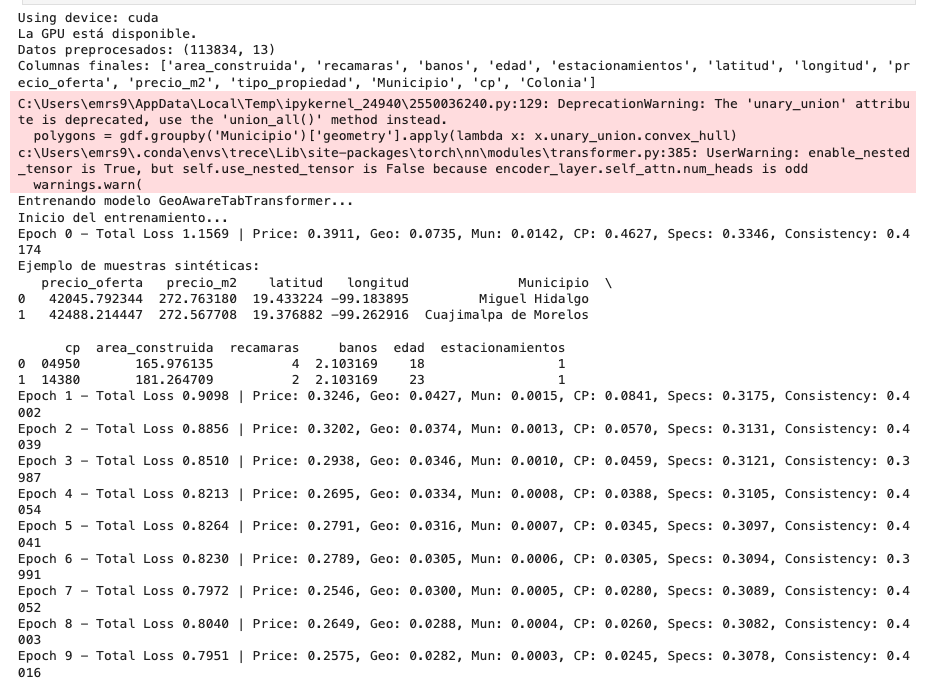

#### Conclusiones

- Se observa una disminución constante en la pérdida total a lo largo de los 10 epochs, lo que sugiere que el modelo está aprendiendo.
- La pérdida total disminuyó de 1.1569 en el epoch 0 a 0.7951 en el epoch 9, indicando un buen ajuste.
- Componentes de la pérdida:
    - Price (Precio): Se redujo de 0.3911 a 0.2575, mejorando la predicción de precios.
    - Geo (Ubicación geográfica): Disminuyó de 0.0735 a 0.0282, sugiriendo que el modelo está mejorando en la coherencia geográfica.
    - Mun (Municipio): Bajó de 0.0142 a 0.0003, mostrando que el modelo ahora clasifica municipios con alta precisión.
    - CP: Redujo su pérdida de 0.4627 a 0.0245, indicando una mejor asignación de códigos postales.
    - Specs (Características de la propiedad): Mantiene una estabilidad en torno a 0.30, indicando que las características estructurales no varían mucho en su contribución al error.
    - Consistency (Coherencia): Se mantiene alrededor de 0.40, lo que sugiere que aún hay margen de mejora en la consistencia de los datos.

Aunque el modelo ha mostrado una mejora en términos de métricas globales y es capaz de generar muestras geográficamente consistentes, aún se pueden observar discrepancias en detalles finos que son evidentes para un experto. El ejemplo de la casa de 165 m² con 4 recámaras y 2.10 baños en Miguel Hidalgo ilustra que, a pesar de un buen desempeño general, es necesario afinar el modelo e incorporar información y restricciones adicionales para garantizar que las predicciones se ajusten a las realidades específicas de cada zona. 


## Enfoque 3

Este código implementa un Variational Autoencoder (VAE) basado en Transformer para datos tabulares. Su objetivo es generar datos sintéticos realistas a partir de un conjunto de datos tabulares, utilizando una arquitectura inspirada en TabTransformer y un enfoque de compresión latente característico de los VAEs.

- Entrada:
    - Variables numéricas (escaladas).
    - Variables categóricas (convertidas en embeddings).
- Encoder:
    - Se usa un Transformer para procesar las características.
    - Se obtiene la media (mu) y la varianza logarítmica (logvar) del espacio latente.
- Reparametrización:
    - Se usa la técnica de reparametrización de VAE:

z=μ+ϵ⋅σ

donde 

ϵ es ruido aleatorio y σ=exp(0.5⋅logvar)

- Decoder:
    - A partir de z, genera valores reconstruidos de las variables numéricas y categóricas.

- Loss:
    - MSE para variables numéricas.
    - Cross-Entropy para variables categóricas.
    - KL-Divergence para regularizar el espacio latente.

In [59]:
# ===============================
# 1. Definición del Modelo VAE con Transformer
# ===============================

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(x + attn_output)
        ff_output = self.ff(x)
        x = self.norm2(x + ff_output)
        return x

class TabTransformerVAE(nn.Module):
    def __init__(self, num_numerical, cat_cardinalities, embed_dim, num_heads, num_layers, latent_dim, dropout=0.1):
        """
        Parámetros:
          - num_numerical: número de features numéricas.
          - cat_cardinalities: lista con la cantidad de categorías de cada feature categórica.
          - embed_dim: dimensión de los embeddings.
          - num_heads: número de cabezas de atención.
          - num_layers: cantidad de bloques transformer.
          - latent_dim: dimensión del espacio latente.
          - dropout: tasa de dropout.
        """
        super().__init__()
        self.num_numerical = num_numerical
        self.cat_cardinalities = cat_cardinalities
        self.num_categorical = len(cat_cardinalities)

        # Embeddings para variables categóricas
        self.cat_embeds = nn.ModuleList([nn.Embedding(card, embed_dim) for card in cat_cardinalities])
        # Proyección para variables numéricas
        self.num_projection = nn.Linear(num_numerical, embed_dim)
        # Token CLS
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        # Bloques transformer
        self.transformer_layers = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, dropout) for _ in range(num_layers)
        ])

        # Obtención del vector latente a partir del token CLS
        self.fc_mu = nn.Linear(embed_dim, latent_dim)
        self.fc_logvar = nn.Linear(embed_dim, latent_dim)

        # Decodificador: salida = [num_numerical] + [sum(cat_cardinalities)]
        total_cat_dims = sum(cat_cardinalities)
        decoder_output_dim = num_numerical + total_cat_dims
        hidden_dim = 128
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, decoder_output_dim)
        )

    def encode(self, numerical_data, categorical_data):
        batch_size = numerical_data.size(0)
        num_feat = self.num_projection(numerical_data).unsqueeze(1)
        cat_feats = [embed(categorical_data[:, i]).unsqueeze(1)
                     for i, embed in enumerate(self.cat_embeds)]
        x = torch.cat([num_feat] + cat_feats, dim=1)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x.transpose(0, 1)
        for layer in self.transformer_layers:
            x = layer(x)
        x = x.transpose(0, 1)
        cls_output = x[:, 0, :]
        mu = self.fc_mu(cls_output)
        logvar = self.fc_logvar(cls_output)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        recon = self.decoder(z)
        num_recon = recon[:, :self.num_numerical]
        cat_recon = []
        start = self.num_numerical
        for card in self.cat_cardinalities:
            end = start + card
            cat_recon.append(recon[:, start:end])
            start = end
        return num_recon, cat_recon

    def forward(self, numerical_data, categorical_data):
        mu, logvar = self.encode(numerical_data, categorical_data)
        z = self.reparameterize(mu, logvar)
        num_recon, cat_recon = self.decode(z)
        return num_recon, cat_recon, mu, logvar

# ===============================
# 2. Preparación de los Datos
# ===============================

df = pd.read_csv("final.csv")
df = df.drop(columns=["indice"])
# Convertimos algunas columnas a string para categorizarlas
df['estacionamientos'] = df['estacionamientos'].astype(int).astype(str)
df['edad'] = df['edad'].astype(int).astype(str)

# Definir columnas según lo que queremos modelar
numerical_cols = ['area_construida', 'latitud', 'longitud', 'precio_oferta', 'precio_m2']
categorical_cols = ['tipo_propiedad', 'Municipio', 'Colonia', 'cp', 'estacionamientos', 'edad', 'recamaras', 'banos']

# Escalado: creamos un scaler para cada columna numérica
scalers = {}
for col in numerical_cols:
    scaler = StandardScaler()
    df[[col]] = scaler.fit_transform(df[[col]])
    scalers[col] = scaler

# Mostrar cardinalidades de las categóricas
cat_cardinalities = {col: df[col].nunique() for col in categorical_cols}
print("Cardinalidades de variables categóricas:", cat_cardinalities)

# Crear mapeos para las variables categóricas
cat_mapping = {}
reverse_cat_mapping = {}
for col in categorical_cols:
    categories = df[col].astype('category').cat.categories
    mapping = {cat: code for code, cat in enumerate(categories)}
    reverse_mapping = {code: cat for code, cat in enumerate(categories)}
    cat_mapping[col] = mapping
    reverse_cat_mapping[col] = reverse_mapping

class TabularDataset(Dataset):
    def __init__(self, df, numerical_cols, categorical_cols, cat_mapping):
        self.numerical_data = df[numerical_cols].to_numpy(dtype=np.float32)
        self.categorical_data = np.stack([
            df[col].map(cat_mapping[col]).to_numpy(dtype=np.int64)
            for col in categorical_cols
        ], axis=1)

    def __len__(self):
        return len(self.numerical_data)

    def __getitem__(self, idx):
        num = torch.tensor(self.numerical_data[idx])
        cat = torch.tensor(self.categorical_data[idx])
        return num, cat

dataset = TabularDataset(df, numerical_cols, categorical_cols, cat_mapping)
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# ===============================
# 3. Entrenamiento y Checkpoints / Logging
# ===============================

embed_dim = 8
num_heads = 2
num_layers = 2
latent_dim = 16
cat_card_list = [cat_cardinalities[col] for col in categorical_cols]

model = TabTransformerVAE(num_numerical=len(numerical_cols),
                          cat_cardinalities=cat_card_list,
                          embed_dim=embed_dim,
                          num_heads=num_heads,
                          num_layers=num_layers,
                          latent_dim=latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
mse_loss_fn = nn.MSELoss()

# Parámetros para checkpoints y log
checkpoint_path = "checkpoint.pt"
log_csv_path = "training_log.csv"

# Si existe un checkpoint, cargar estado
start_epoch = 0
global_step = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    global_step = checkpoint["global_step"]
    print(f"Cargando checkpoint del epoch {start_epoch}")

# Si no existe el CSV de log, crearlo con header
if not os.path.exists(log_csv_path):
    with open(log_csv_path, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["timestamp", "epoch", "loss_total", "loss_num", "loss_cat", "loss_kl"])

num_epochs = 1500

for epoch in range(start_epoch, num_epochs):
    epoch_loss_total = 0.0
    epoch_loss_num = 0.0
    epoch_loss_cat = 0.0
    epoch_loss_kl = 0.0
    num_batches = 0

    for numerical_batch, categorical_batch in dataloader:
        optimizer.zero_grad()
        num_recon, cat_recon, mu, logvar = model(numerical_batch, categorical_batch)

        loss_num = mse_loss_fn(num_recon, numerical_batch)
        loss_cat = 0.0
        for i in range(len(categorical_cols)):
            loss_cat += F.cross_entropy(cat_recon[i], categorical_batch[:, i])
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

        loss = loss_num + loss_cat + kl_loss
        loss.backward()
        optimizer.step()

        epoch_loss_total += loss.item()
        epoch_loss_num += loss_num.item()
        epoch_loss_cat += loss_cat.item()
        epoch_loss_kl += kl_loss.item()
        num_batches += 1
        global_step += 1

        if global_step % 100_000 == 0:
            model.eval()
            with torch.no_grad():
                synthetic_batch_size = 5
                z = torch.randn(synthetic_batch_size, latent_dim)
                num_syn, cat_syn_logits = model.decode(z)
                num_syn_np = num_syn.cpu().numpy()

                synthetic_nums = []
                for i, col in enumerate(numerical_cols):
                    col_vals = num_syn_np[:, i].reshape(-1, 1)
                    col_inv = scalers[col].inverse_transform(col_vals).flatten()
                    synthetic_nums.append(col_inv)
                synthetic_nums = np.column_stack(synthetic_nums)

                synthetic_cat = []
                for i, logits in enumerate(cat_syn_logits):
                    preds = torch.argmax(logits, dim=1).cpu().numpy()
                    preds = [reverse_cat_mapping[categorical_cols[i]][p] for p in preds]
                    synthetic_cat.append(preds)
                synthetic_cat = np.column_stack(synthetic_cat)

                synthetic_df = pd.DataFrame(synthetic_nums, columns=numerical_cols)
                for i, col in enumerate(categorical_cols):
                    synthetic_df[col] = synthetic_cat[:, i]

                print(f"\n[Step {global_step}] Ejemplo de datos sintéticos:")
                print(synthetic_df.head())
            model.train()

    avg_loss_total = epoch_loss_total / num_batches
    avg_loss_num = epoch_loss_num / num_batches
    avg_loss_cat = epoch_loss_cat / num_batches
    avg_loss_kl = epoch_loss_kl / num_batches

    print(f"Epoch {epoch+1}/{num_epochs} - Loss Total: {avg_loss_total:.4f} | Num Loss: {avg_loss_num:.4f} | Cat Loss: {avg_loss_cat:.4f} | KL Loss: {avg_loss_kl:.4f}")

    # Guardar log en CSV (agregar una fila)
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    with open(log_csv_path, mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([timestamp, epoch+1, avg_loss_total, avg_loss_num, avg_loss_cat, avg_loss_kl])

    # Guardar checkpoint cada época (o cada N epochs)
    checkpoint = {
        "epoch": epoch,
        "global_step": global_step,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
    }
    torch.save(checkpoint, checkpoint_path)

Cardinalidades de variables categóricas: {'tipo_propiedad': 2, 'Municipio': 16, 'Colonia': 1222, 'cp': 950, 'estacionamientos': 11, 'edad': 91, 'recamaras': 11, 'banos': 11}
Cargando checkpoint del epoch 1500


/var/folders/ns/82j_1hfj7f188gzxpzd27zfh0000gn/T/ipykernel_81561/905615924.py:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [91]:
synthetic_batch_size = 113000
z = torch.randn(synthetic_batch_size, latent_dim)
num_syn, cat_syn_logits = model.decode(z)
num_syn_np = num_syn.detach().numpy()

synthetic_nums = []
for i, col in enumerate(numerical_cols):
    col_vals = num_syn_np[:, i].reshape(-1, 1)
    col_inv = scalers[col].inverse_transform(col_vals).flatten()
    synthetic_nums.append(col_inv)
synthetic_nums = np.column_stack(synthetic_nums)

synthetic_cat = []
for i, logits in enumerate(cat_syn_logits):
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    preds = [reverse_cat_mapping[categorical_cols[i]][p] for p in preds]
    synthetic_cat.append(preds)
synthetic_cat = np.column_stack(synthetic_cat)

synthetic_df = pd.DataFrame(synthetic_nums, columns=numerical_cols)
for i, col in enumerate(categorical_cols):
    synthetic_df[col] = synthetic_cat[:, i]

In [93]:
synthetic_df.sample(10)

,area_construida,latitud,longitud,precio_oferta,precio_m2,tipo_propiedad,Municipio,Colonia,cp,estacionamientos,edad,recamaras,banos
81466,144.989777,19.402901,-99.173019,38803.304688,283.905548,Departamento,Cuauhtémoc,Polanco,11560,0,0,2,2
21837,144.989777,19.402901,-99.173019,38803.304688,283.905548,Departamento,Cuauhtémoc,Polanco,11560,0,0,2,2
6098,113.534538,19.380775,-99.212700,29351.103516,266.529907,Departamento,Miguel Hidalgo,Anahuac,11320,0,0,2,2
47625,144.989777,19.402901,-99.173019,38803.304688,283.905548,Departamento,Cuauhtémoc,Polanco,11560,0,0,2,2
71531,144.989777,19.402901,-99.173019,38803.304688,283.905548,Departamento,Cuauhtémoc,Polanco,11560,0,0,2,2
47522,144.989777,19.402901,-99.173019,38803.304688,283.905548,Departamento,Cuauhtémoc,Polanco,11560,0,0,2,2
4700,144.989777,19.402901,-99.173019,38803.304688,283.905548,Departamento,Cuauhtémoc,Polanco,11560,0,0,2,2
1638,204.578659,19.372684,-99.247406,44746.253906,241.912491,Departamento,Cuajimalpa de Morelos,Cuajimalpa,5000,0,0,3,2
101681,144.989777,19.402901,-99.173019,38803.304688,283.905548,Departamento,Cuauhtémoc,Polanco,11560,0,0,2,2
108146,82.816010,19.398197,-99.170532,26593.552734,290.094177,Departamento,Benito Juárez,Nonoalco,3020,0,0,2,2


#### Conclusiones

Evaluación de las Pérdidas

- Pérdida Numérica (MSE):
    - Con valores en torno a 0.295, indica que la reconstrucción de las variables numéricas es razonablemente precisa.
- Pérdida Categórica (Cross-Entropy):
    - Valores alrededor de 0.84 sugieren que la reconstrucción de las variables categóricas también se está manejando de forma consistente.
- Pérdida KL:
    - Con valores cercanos a 1.215, la regularización del espacio latente se mantiene constante, lo cual es crucial para la calidad de la reparametrización en el VAE.

Esta división de pérdidas y su estabilidad son exactamente lo que se esperaba del entrenamiento de un VAE con Transformer.

En la muestra se observa que el campo area_construida tiene valores variados, y los datos categóricos (como tipo_propiedad, Municipio, Colonia, etc.) se muestran en formatos coherentes con las categorías originales. Esto confirma que el proceso de decodificación en el VAE, tal como se implementa en el método decode, está funcionando correctamente.

La coherencia entre variables (por ejemplo, un área construida moderada con precios y precio/m² en rangos esperados para zonas exclusivas) sugiere que el modelo ha aprendido bien la correlación entre los diferentes atributos.

In [94]:
# Guardar el DataFrame original
df_CDMX.to_csv("df_CDMX.csv", index=False)

# Guardar el DataFrame sintético
synthetic_df.to_csv("df_sintetico.csv", index=False)


In [95]:
df_CDMX = pd.read_csv("df_CDMX.csv")
df_sintetico = pd.read_csv("df_sintetico.csv")

# Mostrar las primeras filas para verificar
print(df_CDMX.head())
print(df_sintetico.head())

  tipo_propiedad  area_construida  recamaras  banos  edad  estacionamientos  \
0   Departamento             74.0          3      2     5                 1   
1   Departamento            200.0          3      3     7                 3   
2   Departamento             74.0          3      1     0                 0   
3   Departamento             45.0          1      1     0                 0   
4   Departamento             65.0          2      1     0                 0   

     latitud   longitud            Municipio                        Colonia  \
0  19.464082 -99.120232    Gustavo A. Madero              Guadalupe Tepeyac   
1  19.382607 -99.161064        Benito Juárez               Del Valle Centro   
2  19.508087 -99.136730    Gustavo A. Madero                    Sierravista   
3  19.475753 -99.175971         Azcapotzalco  Un Hogar Para Cada Trabajador   
4  19.442391 -99.096380  Venustiano Carranza                   Romero Rubio   

   precio_oferta fecha_oferta   precio_m2       cp

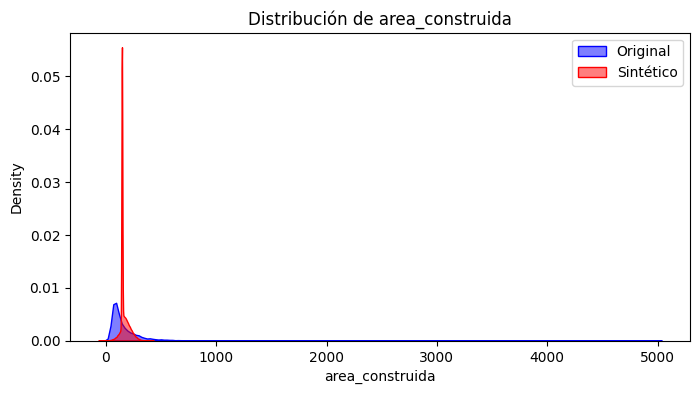

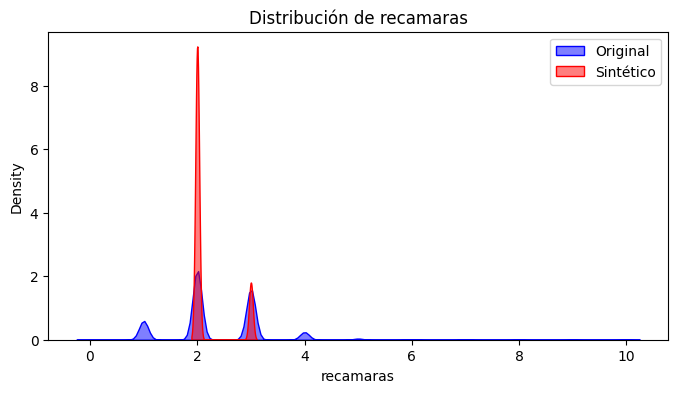

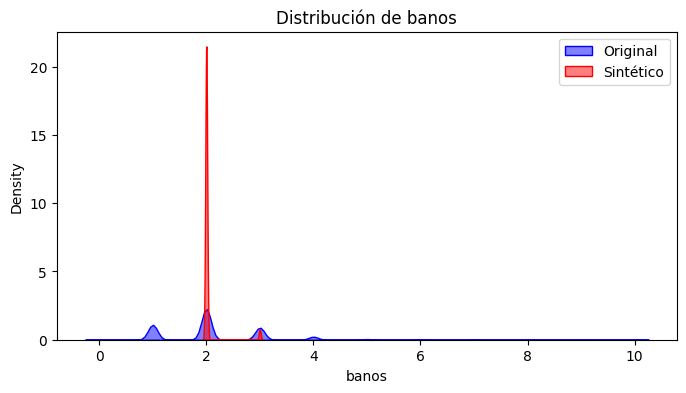

/var/folders/ns/82j_1hfj7f188gzxpzd27zfh0000gn/T/ipykernel_81561/3248802160.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df_sintetico[col], label='Sintético', fill=True, color='red', alpha=0.5)


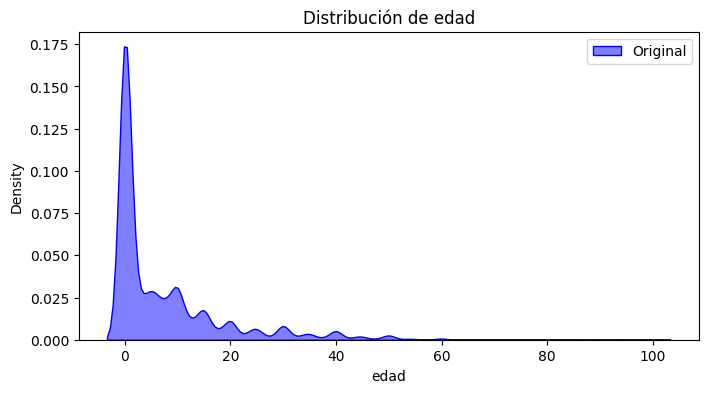

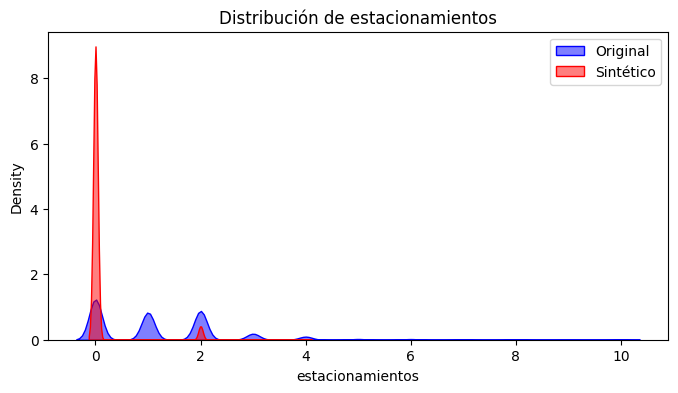

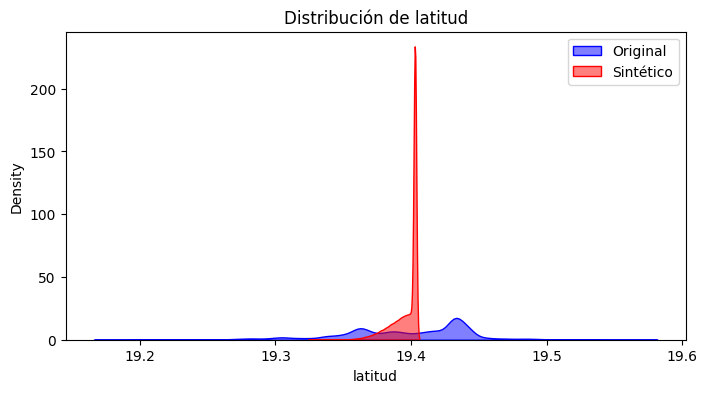

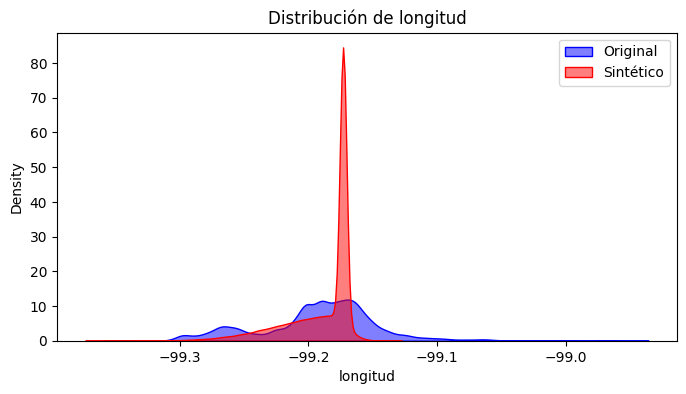

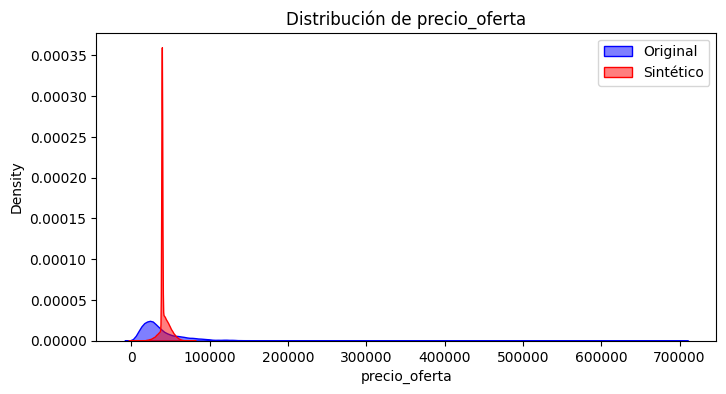

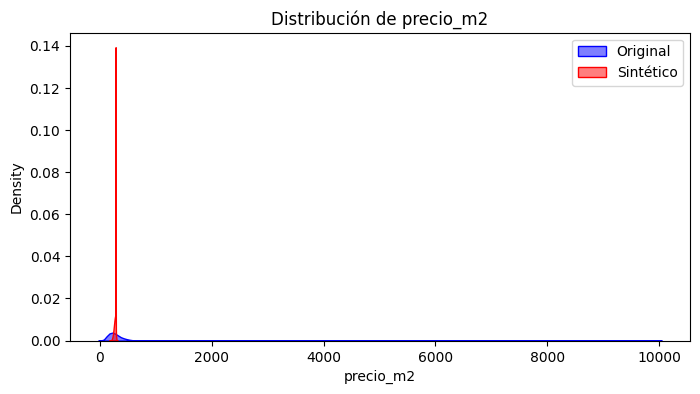

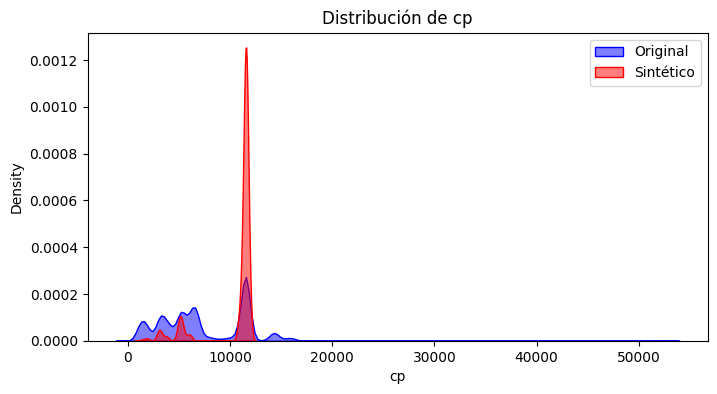

In [96]:
# Seleccionar solo columnas numéricas
num_cols = df_CDMX.select_dtypes(include=['number']).columns

# Graficar distribuciones
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(df_CDMX[col], label='Original', fill=True, color='blue', alpha=0.5)
    sns.kdeplot(df_sintetico[col], label='Sintético', fill=True, color='red', alpha=0.5)
    plt.title(f'Distribución de {col}')
    plt.legend()
# Aplicar la máscara en el DataFrame original
df_filtrado = df_CDMX[df_CDMX["precio_oferta"] <= 30000]

# O, si quieres hacerlo para el DataFrame sintético:
synthetic_df_filtrado = synthetic_df[synthetic_df["precio_oferta"] <= 30000]    plt.show()

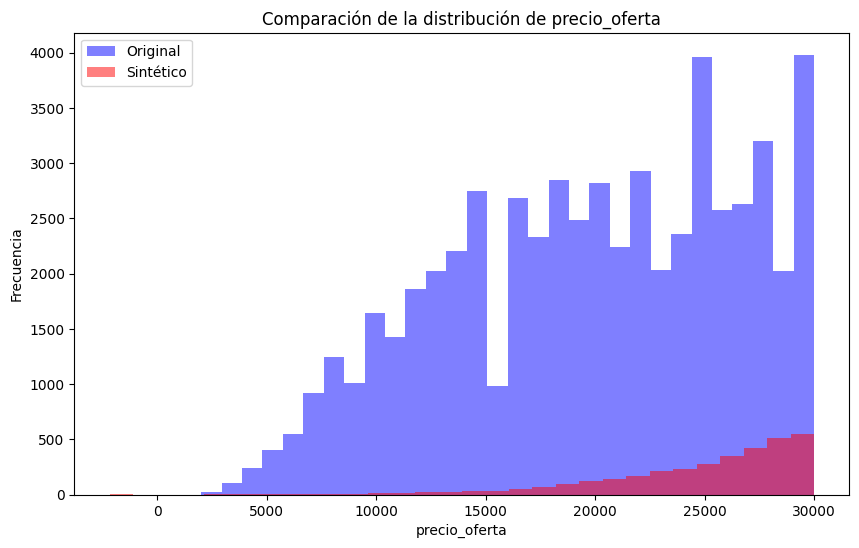

In [99]:
# Aplicar la máscara en el DataFrame original
df_filtrado = df_CDMX[df_CDMX["precio_oferta"] <= 30000]

# O, si quieres hacerlo para el DataFrame sintético:
synthetic_df_filtrado = synthetic_df[synthetic_df["precio_oferta"] <= 30000]

# Definir el número de bins (ajustarlo según la dispersión de los datos)
bins = 30

plt.figure(figsize=(10,6))

# Histograma para los datos originales
plt.hist(df_filtrado["precio_oferta"], bins=bins, alpha=0.5, color="blue", label="Original")

# Histograma para los datos sintéticos
plt.hist(synthetic_df_filtrado["precio_oferta"], bins=bins, alpha=0.5, color="red", label="Sintético")

# Etiquetas y título
plt.xlabel("precio_oferta")
plt.ylabel("Frecuencia")
plt.title("Comparación de la distribución de precio_oferta")
plt.legend()

plt.show()
